###  Libraries

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans, GlobalKernelKMeansPP 
from Rings import Rings
from Common_Modules.Evaluation import Evaluator
from Common_Modules.Graph import Graph

### Global Variables

In [ ]:
seed = 42
evaluator = Evaluator()
graph_is_enabled = False
kMeans_is_enabled = False
kernelKMeans_is_enabled = False
kernelKMeansPP_is_enabled = True
globalKernelKMeans_is_enabled = True
globalKernelKMeansPP_is_enabled = True

### Load Dataset

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']
centers_coordinates = [(-1, 2), (2, 2), (2, 5), (2, -1), (5, 2), (6, 6), (-2, 6), (2, 8), (6, -2), (2, -4), (-2, -2)]

rings = Rings(colors)
X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=100, factor=0.2, noise=0.0)

K = 2 * len(centers_coordinates)
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)

### Create Graph

In [ ]:
if(graph_is_enabled):
    # Number of nodes per community
    n_nodes_per_community = 10

    # Number of communities
    K = n_communities = 10
    
    # Probability of intra-community edge
    p_intra = 1  
    
    # Probability of inter-community edge
    p_inter = 0.01  

    graph = Graph(n_communities, n_nodes_per_community, p_intra, p_inter, colors)
    graph.create_adj_matrix()
    kernel_matrix = graph.adj_matrix = pairwise_kernels(graph.adj_matrix, graph.adj_matrix, metric='rbf', gamma=0.1)
    graph.create_kernel_matrix_from_adj_matrix()

### kMeans

In [ ]:
if(kMeans_is_enabled):
    kmeans = KMeans(n_clusters=K).fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
    evaluator.print_evaluation()
    rings.plot(X, kmeans.labels_)

### Kernel kMeans

In [ ]:
if(kernelKMeans_is_enabled):
    kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
    evaluator.print_evaluation()
    rings.plot(X, kernel_kmeans.labels_)

### Kernel kMeans++

In [ ]:
if(kernelKMeansPP_is_enabled):
    kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=10, init='k-means++', verbose=1)
    kernelKMeans.fit()
    
    if graph_is_enabled:
        graph.plot_clusters(kernelKMeans.labels_)
    else:
        acc, pur, nmi, ari = evaluator.evaluate_model(y, kernelKMeans.labels_)
        evaluator.print_evaluation()
        rings.plot(X, kernelKMeans.labels_)

        # That's the function of grount truth error
        ground_truth_error = kernelKMeans.calculate_ground_truth_error(y)
        print(f"Ground Truth Error is: {ground_truth_error}")

### Global Kernel kMeans

Solved 2-means MSE: 1000.8450100500729
Solving Kernel 3-means
Solved 3-means MSE: 951.5539209422761
Solving Kernel 4-means
Solved 4-means MSE: 902.2436346080831
Solving Kernel 5-means
Solved 5-means MSE: 852.9059236647524
Solving Kernel 6-means
Solved 6-means MSE: 803.7190134350174
Solving Kernel 7-means
Solved 7-means MSE: 754.543059194273
Solving Kernel 8-means
Solved 8-means MSE: 705.39084499709
Solving Kernel 9-means
Solved 9-means MSE: 656.2769767613174
Solving Kernel 10-means
Solved 10-means MSE: 607.2635404452565
Solving Kernel 11-means
Solved 11-means MSE: 558.6426977756715
Solving Kernel 12-means
Solved 12-means MSE: 546.2018856781818
Solving Kernel 13-means
Solved 13-means MSE: 533.7610735806921
Solving Kernel 14-means
Solved 14-means MSE: 521.3202614832024
Solving Kernel 15-means
Solved 15-means MSE: 508.87944938571275
Solving Kernel 16-means
Solved 16-means MSE: 496.43863728822305
Solving Kernel 17-means
Solved 17-means MSE: 483.99782519073335
Solving Kernel 18-means
Solved

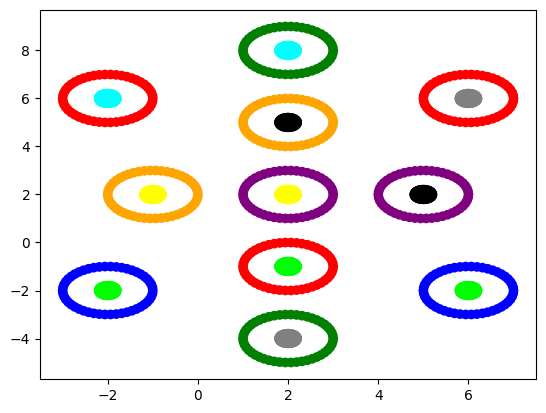

In [8]:
if(globalKernelKMeans_is_enabled):
    globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, verbose=1)
    globalKernelKMeans.fit()

    if graph_is_enabled:
        graph.plot_clusters(globalKernelKMeans.labels_[K])
    else:
        acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeans.labels_[K])
        evaluator.print_evaluation()
        rings.plot(X, globalKernelKMeans.labels_[K])

### Global Kernel kMeans++

Solving 2-means
Solved 2-means MSE: 1000.8450100500729
Solving 3-means
Solved 3-means MSE: 951.5539209422761
Solving 4-means
Solved 4-means MSE: 902.2436346080831
Solving 5-means
Solved 5-means MSE: 852.9059236647524
Solving 6-means
Solved 6-means MSE: 803.7190134350174
Solving 7-means
Solved 7-means MSE: 754.543059194273
Solving 8-means
Solved 8-means MSE: 705.39084499709
Solving 9-means
Solved 9-means MSE: 656.2769767613174
Solving 10-means
Solved 10-means MSE: 607.2635404452565
Solving 11-means
Solved 11-means MSE: 558.6426977756715
Solving 12-means
Solved 12-means MSE: 546.2018856781818
Solving 13-means
Solved 13-means MSE: 533.7610735806921
Solving 14-means
Solved 14-means MSE: 521.3202614832024
Solving 15-means
Solved 15-means MSE: 508.87944938571275
Solving 16-means
Solved 16-means MSE: 496.43863728822305
Solving 17-means
Solved 17-means MSE: 483.99782519073335
Solving 18-means
Solved 18-means MSE: 471.55701309324365
Solving 19-means
Solved 19-means MSE: 459.11620099575396
Solvi

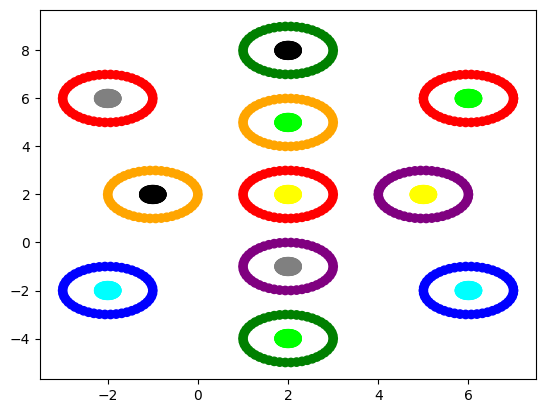

In [10]:
if(globalKernelKMeansPP_is_enabled):
    globalKernelKMeansPP = GlobalKernelKMeansPP(n_clusters=K, kernel_matrix=kernel_matrix, n_candidates=100, sampling='sequential', verbose=1)
    globalKernelKMeansPP.fit()
    
    if graph_is_enabled:
        graph.plot_clusters(globalKernelKMeansPP.labels_[K])
    else:
        acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeansPP.labels_[K])
        evaluator.print_evaluation()
        rings.plot(X, globalKernelKMeansPP.labels_[K])